# Exploring VAE performances in 1D

In [2]:
import numpy as np
import sympy as sp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
#sp.init_session()

## Generate a 1D synthetic data set

We consider the toymodel for $L=1$ and $D=1$.

Generative model: $x_i = w_{true} z_i + \epsilon_i$ for $i = 1...n$ where $z \sim N(0, 1)$ and $\epsilon \sim N(0, 1)$.

The true parameter of the generative model is set to $w_{true} = 2$. The distribution of the data under this generative model is:

\begin{equation}
    p_{data}(x) = N(0, w_{true}^2 + 1) = N(0, 5)
\end{equation}

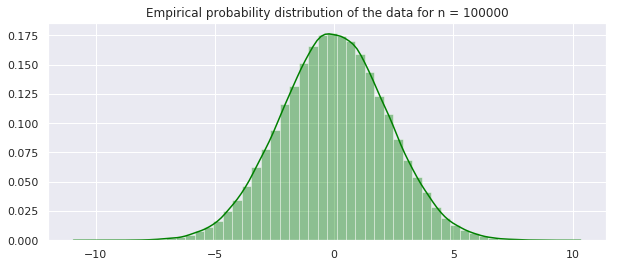

In [73]:
w_true = 2
color_true = 'green'
def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return z, x



n = 100000

fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
z, x = generate_synthetic_1d(n=n)
hist = sns.distplot(x, ax=ax, color=color_true)
title = ax.set_title('Empirical probability distribution of the data for n = %d' % n)

## Choose the generative family, i. e. choose the family of the decoder

We consider the following generative model to represent the decoder:

\begin{equation}
    x = wz + \epsilon \qquad \text{where: $w \in \mathbb{R}$, $z\sim N(0, 1)$ and $\epsilon \sim N(0, 1)$}
\end{equation}
The parameter of the model is $\theta = w$. This model generates data according to:

\begin{equation}
    p_{\theta}(x) = p_{w}(x) = N(0, w^2 + 1)
\end{equation}

**Remark**: This means that we consider a decoder with one linear layer and no bias.

This model can exactly recover the distribution $p_{data}(x) = $ if $w = w_{true} = 2$.

We have: $x | z \sim N(wz, 1)$ and the true posterior is $z |x \sim N\left(\frac{wx}{1+w^2}, \frac{1}{1+w^2}\right)$. 

## Choose the variational family, i. e. choose the family of the encoder

We consider the following variational distribution:

\begin{equation}
    q_\phi(z | x) = N(\phi x, 1)
\end{equation}

**Remark**: This means that we consider an encoder with one linear layer encoder and no bias to approximate the posterior. We also do not use is to predict the standard deviation, which is constrained to 1.

## Investigate how the parameters $\theta=w$ and $\phi$ score on the LL and the ELBO

### Log-likelihood

We compute the log-likelihood, the ELBO as well as the other objectives.

In [74]:
sigma2 = np.mean(x**2)
w, phi, sig2 = sp.symbols('w, phi, sig2')

loglikelihood = - 1. / 2. * sp.log(2 * sp.pi * (w ** 2 + 1)) - sig2 / (2 * (w ** 2 + 1))

The log-likelihood writes:

\begin{align*}
    L 
    = \mathbb{E}_{p_{data}(x)} \left[ \log p_\theta(x) \right] 
    = \mathbb{E}_{p_{data}(x)} \left[ \log p_w(x) \right] 
    &= -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(1+w^2) -\frac{\hat{\sigma^2}}{2(1+w^2)} \qquad \text{where: $\hat{\sigma^2} = \frac{1}{n}\sum_{i=1}^n[x_i^2]$.}
\end{align*}

The ML estimator for $w$ is: $w^2 = \hat{\sigma^2} - 1$.

In [75]:
loglikelihood

-sig2/(2*w**2 + 2) - 0.5*log(2*pi*(w**2 + 1))

In [76]:
def argmaxima_likelihood(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

def maxima_likelihood(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    argmaxima = argmaxima_likelihood(expr, x)
    maxima = [expr.subs(w, argmax) for argmax in argmaxima]
    maxima = [sp.N(sp.simplify(maximum)) for maximum in maxima]
    return maxima

In [77]:
print('The parameters w maximizing the log likelihood is: \nw = ', argmaxima_likelihood())
print('\n')

print('The value of the log likelihood at maximum is:')
print(maxima_likelihood())

The parameters w maximizing the log likelihood is: 
w =  [0.0, -sqrt(sig2 - 1.0), sqrt(sig2 - 1.0)]


The value of the log likelihood at maximum is:
[-0.5*sig2 - 0.918938533204673, -0.5*log(2*pi*sig2) - 0.5, -0.5*log(2*pi*sig2) - 0.5]


### Two computations of ELBO

The ELBO can be defined from the log-likelihood:

\begin{align*}
    L_{ELBO} 
  = L - KL_{posterior}(\phi, \theta) 
  = \mathbb{E}_{p_{data}(x)} \left[ \log p_\theta(x) - KL\left(q_\phi(z|x) || p_\theta(z|x)\right) \right] 
\end{align*}

or from the unregularized VAE:

\begin{align*}
    L_{ELBO} 
  = L_{UVAE} - KL_{prior}(\phi) 
  = \mathbb{E}_{p_{data}(x)}\left[ \mathbb{E}_{q_\phi(z|x)} \left[\log p_\theta(x|z)\right] - KL\left(q_\phi(z|x) || p(z)\right) \right] 
\end{align*}

We have the loglikelihood already. We compute the remaining 3 terms and see if they form $L_{ELBO}$. We start by computing the KL divergences. We recall the formula for KL divergences in 1D:

\begin{align*}
    KL\left(N(\mu_1, \sigma_1^2) || N(\mu_2, \sigma_2^2)\right)
    & = \frac{1}{2}\log\frac{\sigma_2^2}{\sigma_1^2} + \frac{\sigma_1^2}{2\sigma^2_2} + \frac{(\mu_2 - \mu_1)^2}{2\sigma^2_2} - \frac{1}{2}
\end{align*}

We compute the $KL_{posterior}$ between the approximate posterior and the decoder's posterior:

\begin{align*}
    KL\left(q_\phi(z|x) || p_w(z | x)\right) 
 &= KL\left(N(\phi x, 1) || N(\frac{wx}{1+w^2}, \frac{1}{1+w^2})\right) \\
 &= - \frac{1}{2}\log(1+w^2) + \frac{1}{2}(1+w^2) + \frac{1}{2} \frac{\left(w - \phi - \phi w^2\right)^2}{1+w^2}x^2 - \frac{1}{2}
\end{align*}

In [78]:
klposterior = - 1. / 2. * sp.log(1+ w ** 2) + 1. /2. * (1 + w ** 2 ) + 1. / 2. * (w - phi - phi * w**2) ** 2 * sig2 / (1 + w**2) - 1. / 2.
klposterior

0.5*sig2*(-phi*w**2 - phi + w)**2/(w**2 + 1) + 0.5*w**2 - 0.5*log(w**2 + 1)

We see that, when $w$ is fixed to its current estimate, the optimal $\phi$ is: $\phi = \frac{w}{1+w^2}$. 

In [79]:
def optimal_phi_for_w_fixed(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_phi = sp.diff(expr, phi)
    dexpr_phi = sp.simplify(dexpr_phi)
    argmaxima = sp.solve(dexpr_phi, phi)
    return argmaxima

def optimal_w_for_phi_fixed(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

print(optimal_phi_for_w_fixed(expr=klposterior))
print(optimal_w_for_phi_fixed(expr=klposterior))

[w/(w**2 + 1.0)]
[]


We also compute the $KL_{prior}$ between the approximate posterior and the prior:

\begin{align*}
KL \left(q_\phi(z|x) || p(z) \right) = KL \left(N(\phi x, 1) || N(0, 1) \right)  = \frac{\phi^2 x^2}{2}
\end{align*}

Here, the optimal $\phi$ that brings the regularization to $0$ is $\phi = 0$.

In [80]:
klprior = 1. /2. * (phi ** 2 * sig2)
klprior

0.5*phi**2*sig2

We can compute the unregularized VAE:

\begin{align*}
    L_{UVAE} 
    &= \mathbb{E}_{p_{data}(x)} \mathbb{E}_{q(z|x)} \left[\log p_w(x|z) \right] \\
    &= \mathbb{E}_{p_{data}(x)} \mathbb{E}_{q(z|x)} \left[\log N(wz, 1) \right] \\
    &= - \frac{1}{2}\log(2\pi) - \frac{1}{2}w^2 - \frac{1}{2}\left(1 - w\phi\right)^2 \hat{\sigma^2}
\end{align*}

In [81]:
uvae = - 1. / 2. * sp.log(2 * sp.pi) - w ** 2 / 2.  - 1. /2. * (1. - w * phi) ** 2 * sig2
uvae

-0.5*sig2*(-phi*w + 1.0)**2 - 0.5*w**2 - 0.5*log(2*pi)

In [82]:
print(optimal_phi_for_w_fixed(expr=uvae))
print(optimal_w_for_phi_fixed(expr=uvae))

[1/w]
[phi*sig2/(phi**2*sig2 + 1.0)]


We check that the two expressions of the $L_{ELBO}$ match, and match the expression computed by hand:

\begin{align*}
    L_{ELBO} 
    &= \frac{1}{2}(1 - \log(2\pi)) - \frac{1}{2}\log\left(\frac{1+w^2}{w^2}\right) -\frac{1}{2}w^2 - \frac{\hat{\sigma^2}}{2}\left(\frac{1}{1+w^2} +(1-\phi w )^2\right)
\end{align*}

In [83]:
elbo = loglikelihood - klposterior
elbo  # Ok with expression above

-sig2/(2*w**2 + 2) - 0.5*sig2*(-phi*w**2 - phi + w)**2/(w**2 + 1) - 0.5*w**2 - 0.5*log(2*pi*(w**2 + 1)) + 0.5*log(w**2 + 1)

In [84]:
elbo_from_uvae = uvae - klprior
elbo_from_uvae

-0.5*phi**2*sig2 - 0.5*sig2*(-phi*w + 1.0)**2 - 0.5*w**2 - 0.5*log(2*pi)

In [85]:
diff = sp.simplify(elbo - elbo_from_uvae)
assert diff == 0, diff

In [86]:
print(optimal_phi_for_w_fixed(expr=elbo))
print(optimal_w_for_phi_fixed(expr=elbo))

[w/(w**2 + 1.0)]
[phi*sig2/(phi**2*sig2 + 1.0)]


In [87]:
def plot_landscape(ax, expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100), cmap='Spectral'):
    sigma2 = np.mean(x**2)

    uu, vv = np.meshgrid(u, v)
    
    if not phi in expr.free_symbols:
        f = sp.utilities.lambdify(w, expr.subs(sig2, sigma2), 'numpy')
        c = ax.contourf(uu, vv, f(uu), cmap=cmap, levels=100)
    else:
        f = sp.utilities.lambdify((w, phi), expr.subs(sig2, sigma2), 'numpy')
        c = ax.contourf(uu, vv, f(uu, vv), cmap=cmap, levels=100)

    plt.colorbar(c, ax=ax)
    
    ax.set_xlabel('w')
    ax.set_ylabel('phi')
    
    ax.set_xlim((np.min(u), np.max(u))) 
    ax.set_ylim((np.min(v), np.max(v))) 
    
    ax.grid()
    return ax

def plot_optimal_phi_as_function_of_w(ax, expr, x=None, u=np.linspace(-5, 5, 100)):
    phi_expr = optimal_phi_for_w_fixed(expr=expr, x=x)
    phis = [phi_expr[0].subs(w, u_elmt) for u_elmt in u]
    ax.plot(u, phis, color='black', linewidth=1) 
    return ax

def plot_optimal_w_as_function_of_phi(ax, expr, x=None, v=np.linspace(-1.2, 1.2, 100)):
    w_expr = optimal_w_for_phi_fixed(expr=expr, x=x)
    if len(w_expr) == 0:
        print(len(w_expr))
        return ax
    ws = [w_expr[0].subs(phi, v_elmt) for v_elmt in v]
    ax.plot(ws, v, color='grey', linewidth=1) 
    return ax

def get_arg_maximum(expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100)):
    sigma2 = np.mean(x**2)

    uu, vv = np.meshgrid(u, v)
    
    if not phi in expr.free_symbols:
        f = sp.utilities.lambdify(w, expr.subs(sig2, sigma2), 'numpy')
        f_values = f(u)
        f_max = np.max(f_values)
        u_id_argmax = np.where(f(u) == f_max)
        u_argmax = u[u_id_argmax]
        return u_argmax

    else:
        f = sp.utilities.lambdify((w, phi), expr.subs(sig2, sigma2), 'numpy')
        f_values = f(uu, vv)
        f_max = np.max(f_values)
        
        v_id_argmax, u_id_argmax = np.where(f(uu, vv) == f_max)
             
        u_argmax = u[u_id_argmax]
        v_argmax = v[v_id_argmax]
        return u_argmax, v_argmax


def plot_maximum(ax, expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100)):
    if not phi in expr.free_symbols:
        u_argmax = get_arg_maximum(expr, x, u, v)
        ax.axvline(u_argmax, color='red', linewidth=3)  # HACK alert for LL

    else:
        u_argmax, v_argmax = get_arg_maximum(expr, x, u, v)
        ax.scatter(u_argmax, v_argmax, color='red', s=100)
        
    return ax

0


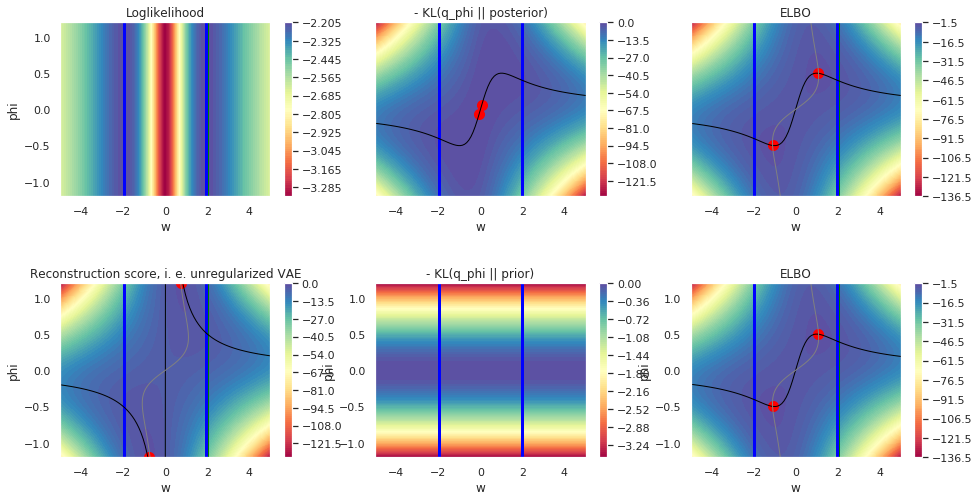

In [92]:
def plot_total(ax, expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100)):
    w_ml = argmaxima_likelihood(x=x)[2]
    ax = plot_landscape(ax, expr, x, u=u, v=v)
    ax.axvline(w_true, color='green', linewidth=3)
    ax.axvline(w_ml, color='blue', linewidth=3)
    ax.axvline(-w_ml, color='blue', linewidth=3)
    return ax

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

#mi = np.min((dfz.min(), xx.min()))
#ma = np.max((dfz.max(), xx.max()))
#norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)

# First row
ax = axes[0, 0]
expr = loglikelihood
ax = plot_total(ax, expr, x)
ax.set_title('Loglikelihood')

ax = axes[0, 1]
expr = -klposterior

ax = plot_total(ax, expr, x)
ax = plot_maximum(ax, expr, x)
ax = plot_optimal_phi_as_function_of_w(ax, expr, x)
ax = plot_optimal_w_as_function_of_phi(ax, expr, x)
ax.get_yaxis().set_visible(False)
ax.set_title('- KL(q_phi || posterior)')

ax = axes[0, 2]
expr = elbo
ax = plot_total(ax, expr, x)
ax = plot_maximum(ax, expr, x)
ax = plot_optimal_phi_as_function_of_w(ax, expr, x)
ax = plot_optimal_w_as_function_of_phi(ax, expr, x)

ax.get_yaxis().set_visible(False)
ax.set_title('ELBO')

# Second row
ax = axes[1, 0]
expr = uvae
ax = plot_total(ax, expr, x)
ax = plot_maximum(ax, expr, x)
ax = plot_optimal_phi_as_function_of_w(ax, expr, x)
ax = plot_optimal_w_as_function_of_phi(ax, expr, x)
ax.set_title('Reconstruction score, i. e. unregularized VAE')

ax = axes[1, 1]
expr = - klprior
ax = plot_total(ax, expr, x)
ax.set_title('- KL(q_phi || prior)')

ax = axes[1, 2]
expr = elbo
ax = plot_total(ax, expr, x)
ax = plot_maximum(ax, expr, x)
ax = plot_optimal_phi_as_function_of_w(ax, expr, x)
ax = plot_optimal_w_as_function_of_phi(ax, expr, x)
ax.set_title('ELBO')

# TODO: share heat scale across maps
#cb = plt.colorbar()

plt.show()

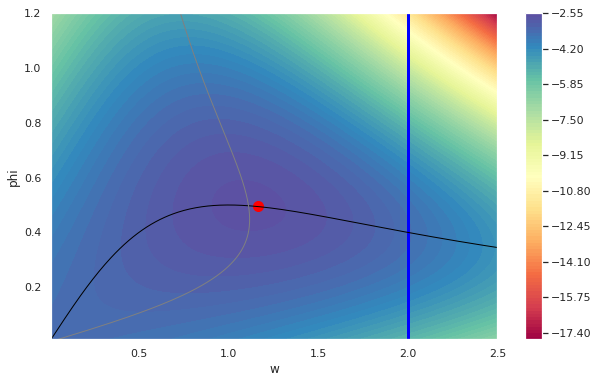

In [89]:
# Zoom
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
def plot_elbo_landscape(ax, x, w_true, u=np.linspace(0.01, 2.5, 300), v=np.linspace(0.01, 1.2, 300)):
    ax = plot_total(ax, elbo, x, u=u, v=v)
    ax = plot_maximum(ax, expr, x)
    ax = plot_optimal_phi_as_function_of_w(ax, expr, x, u=u)
    ax = plot_optimal_w_as_function_of_phi(ax, expr, x, v=v)
    return ax
    
ax = plot_elbo_landscape(axes, x, w_true)

Text(0.5, 1.0, 'n = 100000')

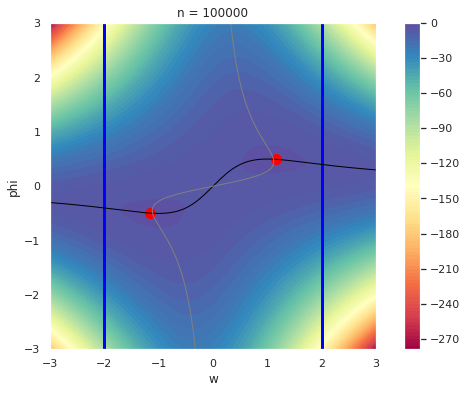

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = plot_elbo_landscape(ax, x, w_true, u=np.linspace(-3, 3, 300), v=np.linspace(-3, 3, 300))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_title('n = %d' % n)

Text(0.5, 1.0, 'n = 10000')

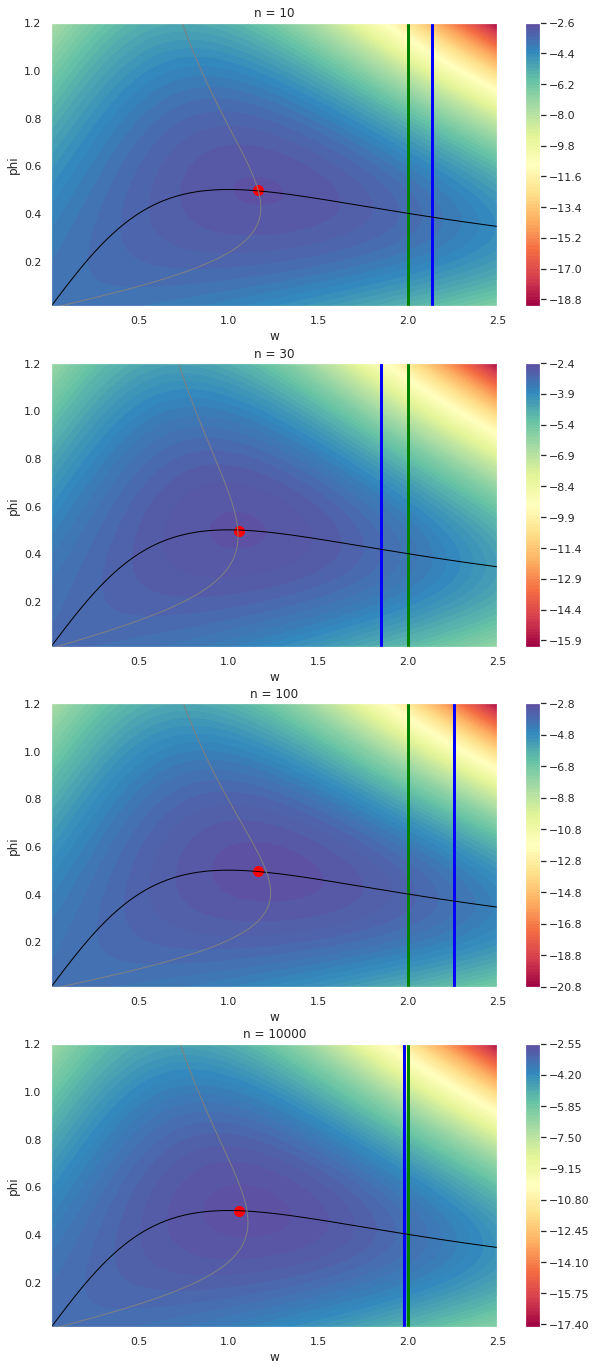

In [66]:
# Study of the ELBO landscape for different sample sizes n
fig, axes = plt.subplots(4, 1, figsize=(10, 24))

n = 10
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[0], x, w_true)
ax.set_title('n = %d' % n)

n = 30
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[1], x, w_true)
ax.set_title('n = %d' % n)

n = 100
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[2], x, w_true)
ax.set_title('n = %d' % n)

n = 10000
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[3], x, w_true)
ax.set_title('n = %d' % n)

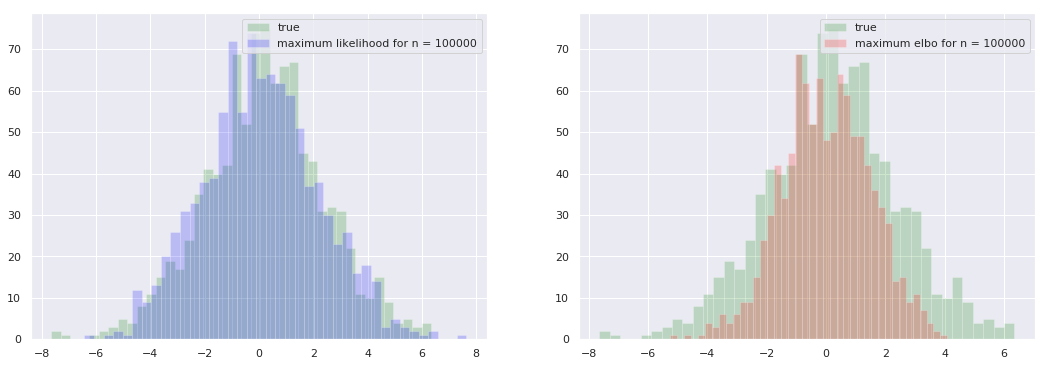

In [91]:
# Generate data with estimated w
n_to_sample = 1000

z, x = generate_synthetic_1d(w=w_true, n=n_to_sample)

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

w_ml = argmaxima_likelihood(x=x)
w_ml = w_ml[2] # Select positive solution
w_ml = np.array(w_ml).astype(np.float64)  # from sympy to numpy

w_argmax, phi_argmax = get_arg_maximum(elbo, x, u, v)  # argmax numerically
w_argmax = w_argmax[0]

z_ml, x_ml = generate_synthetic_1d(w=w_ml, n=n_to_sample)
z_elbo, x_elbo = generate_synthetic_1d(w=w_argmax, n=n_to_sample)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax = axes[0]

alpha = 0.2
bins = 40
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_ml, bins=bins, alpha=alpha, color='blue', label='maximum likelihood for n = %d' % n)
ax.legend(loc='upper right')

ax = axes[1]
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_elbo, bins=bins, alpha=alpha, color='red', label='maximum elbo for n = %d' % n)

ax.legend(loc='upper right')

## Proof of bias in 1D

We replace $\phi$ by its optimal value $\phi = \frac{w}{1+w^2}$ in the elbo criterion. Then, we optimize the ELBO in $w$. We see that it does not get the value of the ML.

In [35]:
elbo

-sig2/(2*w**2 + 2) - 0.5*sig2*(-phi*w**2 - phi + w)**2/(w**2 + 1) - 0.5*w**2 - 0.5*log(2*pi*(w**2 + 1)) + 0.5*log(w**2 + 1)

In [39]:
elbo_in_w = elbo.subs(phi, w / (1 + w ** 2))
elbo_in_w = sp.simplify(elbo_in_w)
elbo_in_w

-(sig2 + 1.0*(w**2 + 1)*(w**2 + log(2) + log(pi)))/(2*w**2 + 2)

In [40]:
def argmaxima(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

def maxima(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    argmaxima = argmaxima_likelihood(expr, x)
    maxima = [expr.subs(w, argmax) for argmax in argmaxima]
    maxima = [sp.N(sp.simplify(maximum)) for maximum in maxima]
    return maxima

In [49]:
w_elbo = argmaxima(expr=elbo_in_w)

In [50]:
w_elbo

[0.0,
 -sqrt(-sig2**0.5 - 1.0),
 sqrt(-sig2**0.5 - 1.0),
 -sqrt(sig2**0.5 - 1.0),
 sqrt(sig2**0.5 - 1.0)]

The optimal $w_{elbo} = \sqrt{\frac{\hat\sigma^2}{2} - 1}$, while $w_{ML} = \sqrt{\hat \sigma^2 -1}$. For $n \rightarrow +\infty$, $\hat \sigma^2 \rightarrow 1+w_{true}^2$. Thus the ML estimate is unbiased, but the elbo estimate is biased. As a result, the generative distribution is biased as a estimate of the distribution of the data. Specifically: its variance is biased. We compute the bias in terms of distributions, which is the KL KL(p_{data} || p_{elbo}), between $p_{data}=p_{w_{true}}= N(0, w_{true}^2+1$ and $p_{w_{elbo}}=N(0, w_{elbo}^2+1$:

In [51]:
w_elbo = w_elbo[-1]

In [54]:
klbias_cst = - 1 / 2
klbias_log = 1 / 2 * sp.log((w_elbo ** 2 + 1) / (w_true ** 2 + 1))
klbias_frac = (w_true ** 2 + 1) / (2 * (w_elbo ** 2 + 1)) 
klbias =  klbias_log + klbias_frac + klbias_cst
klbias = sp.simplify(klbias)
print(klbias)

5*sig2**(-0.5)/2 + log(sig2**0.5/5)/2 - 0.5


The bias in the 1D example is:
\begin{equation}
Bias(p_{elbo}, p_{data}) = KL(p_{data} || p_{elbo}) = - \frac{5}{2\sigma}  + \frac{1}{2} \log(\frac{\sigma}{5}) - \frac{1}{2}
\end{equation}

In [ ]:
# TODOs:
# Look at the reconstruction distribution: 
# - if we distribute z with its posterior.
# - if we distribute z with the marginal of q


def generate_synthetic_1d_from_posterior(w=w_true, n=10, mu, sigma):
    # Sample latent variable, noise -> generate data
    z = np.random.normal(loc=mu, scale=sigma, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))  # PPCA because it is isotropic

    # Generative model
    x = w * z + eps
    return z, x

n = 1000
z, x = generate_synthetic_1d(w=w_true, n=n)

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

w_ml = argmaxima_likelihood(x=x)
w_ml = w_ml[2] # Select positive solution
w_ml = np.array(w_ml).astype(np.float64)  # from sympy to numpy

w_argmax, phi_argmax = get_arg_maximum(elbo, x, u, v)  # argmax numerically
w_argmax = w_argmax[0]


z_post_ml, x_post_ml = generate_synthetic_1d_from_posterior(w=w_true, n=10, mu=phi*x, sigma)

In [ ]:
# Generate data with estimated w
n = 1000

z, x = generate_synthetic_1d(w=w_true, n=n)

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

w_ml = argmaxima_likelihood(x=x)
w_ml = w_ml[2] # Select positive solution
w_ml = np.array(w_ml).astype(np.float64)  # from sympy to numpy

w_argmax, phi_argmax = get_arg_maximum(elbo, x, u, v)  # argmax numerically
w_argmax = w_argmax[0]

z_ml, x_ml = generate_synthetic_1d(w=w_ml, n=n)
z_elbo, x_elbo = generate_synthetic_1d(w=w_argmax, n=n)

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

ax = axes[0, 0]
ax.scatter(z, x, color='green')
ax.scatter(z_ml, x_ml, color='blue')

ax = axes[0, 1]
ax.scatter(z, x, color='green')
ax.scatter(z_elbo, x_elbo, color='red')

ax = axes[1, 0]

alpha = 0.2
bins = 40
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_ml, bins=bins, alpha=alpha, color='blue', label='maximum likelihood for n = %d' % n)
ax.legend(loc='upper right')

ax = axes[1, 1]
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_elbo, bins=bins, alpha=alpha, color='red', label='maximum elbo for n = %d' % n)

ax.legend(loc='upper right')

# Note: This does not take into account the amortization error.
# TODOs:
# - Look at mutual information between x and z.

In [ ]:
z, x = generate_synthetic_1d(n=10)

phi_optimal_expr = argmaxima_phi(expr=elbo)

def ws_and_phis(ws, phi_expr):
    n_optimal_phis = len(phi_expr)
    if n_optimal_phis > 1:
        ws = ws.repeat(ws, n_optimal_phis)
       
    phis = np.array([[phi_elmt.subs(w, w_elmt) for w_elmt in ws] 
                    for phi_elmt in phi_expr])
    return ws, phis
    
def plot_true_best(ax, w_true, x):
    w_true_solutions = np.array([w_true, -w_true])
    w_best_solutions = argmaxima_likelihood(x=x)

    ws_true, phis_true = ws_and_phis(w_true_solutions, phi_optimal_expr)
    ws_best, phis_best = ws_and_phis(w_best_solutions, phi_optimal_expr)
    ax.scatter(ws_true, phis_true, color='green', s=100)
    ax.scatter(ws_best, phis_best, color='blue', s=100)
    return ax

# One quadrant
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

ax = plot_landscape(axes[0], loglikelihood, x, u=u, v=v)
ax = plot_true_best(ax, w_true, x)

ax = plot_landscape(axes[1], elbo, x, u=u, v=v, cmap='Spectral', minima=True)
ax = plot_true_best(axes[1], w_true, x)
ax = plot_maximum(axes[1], elbo, x, u=u, v=v)

# Zoom
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
def plot_elbo_landscape(ax, x, w_true, u=np.linspace(0.5, 2.5, 100), v=np.linspace(0.01, 1.5, 100)):
    ax = plot_landscape(ax, elbo, x, u=u, v=v, cmap='Spectral', minima=True)
    ax = plot_true_best(ax, w_true, x)
    ax = plot_maximum(ax, elbo, x, u=u, v=v)
    return ax
    
ax = plot_elbo_landscape(axes, x, w_true)